**IMPORTING REQUIRED LIBRARIES**

In [3]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import keras
import seaborn as sns
import pathlib
from pathlib import Path
import glob
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils  import to_categorical
from keras.preprocessing.image import ImageDataGenerator


In [4]:
data_dir='/kaggle/input/pneumonia-xray-img-dataset/pneumonia xray'
root_dir='/kaggle/working/'

In [42]:
def countfiles(root_dir):
    for path in pathlib.Path(root_dir).iterdir():
        if path.is_dir():
             print( str(len([name for name in os.listdir(path) \
            if os.path.isfile(os.path.join(path, name))])) + " files inside the " + \
            str(path.name),'class')
countfiles(data_dir)

4273 files inside the PNEUMONIA class
1583 files inside the NORMAL class


**DATASET PREPARATION**

In [5]:
def data_categories(d_path):
    categories=[]    #listdir-->used to get the list of all files and directories in the specified directory
    for folder_name in os.listdir(d_path):  #os.path.isdir()--->used to check whether the specified path is an existing directory or not.
        if os.path.isdir(os.path.join(d_path,folder_name)):
            no_of_files=len(glob.glob(os.path.join(d_path, folder_name)+"/*.jpeg"))
            categories.append(np.array([folder_name,no_of_files]))
    categories.sort(key=lambda a:a[0])
    cat=np.array(categories)
    return list(cat[:, 0]),list(cat[:,1])
categories,no_of_files = data_categories("/kaggle/input/pneumonia-xray-img-dataset/pneumonia xray")
print(categories)

['NORMAL', 'PNEUMONIA']


In [44]:
print("number of categories: ", len(categories))

number of categories:  2


In [68]:
df = pd.DataFrame({"category": categories, "number of files": no_of_files})
df

,category,number of files
0,NORMAL,1583
1,PNEUMONIA,4273


In [6]:
def dataset(data_path, categories, width, height):
    x = []
    y = []
    for category_idx, category in enumerate(categories):
        path = os.path.join(data_path, category)
        count = 0
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path,img))
            img_size = cv2.resize(img_array, (width, height))
            x.append(img_size)
            y.append(category_idx)
            count += 1
        print(f"Number of images in class {category_idx}: {count}")
    y = np.array(y)
    x = np.array(x).reshape(y.shape[0], width, height, 3)
    return x, y

x, y = dataset(data_path=data_dir, categories=['NORMAL', 'PNEUMONIA'], width=200, height=200)


Number of images in class 0: 1583
Number of images in class 1: 4273


In [7]:
print(f'x shape:{x.shape}')
print(f"y shape: {y.shape}")

x shape:(5856, 200, 200, 3)
y shape: (5856,)


**IMAGES FROM CLASSES**

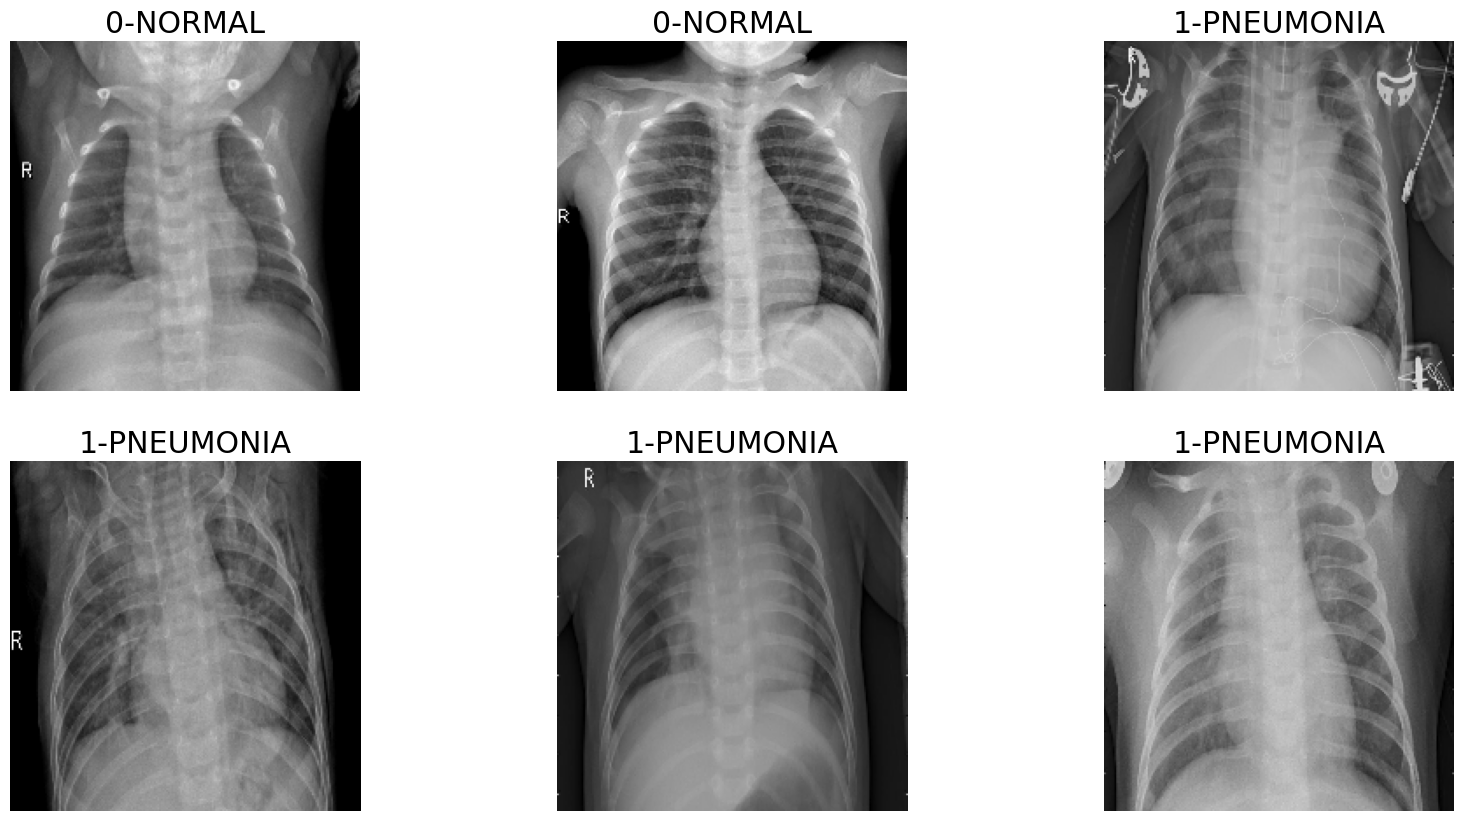

In [129]:
plt.figure(figsize=(20, 10))
st, end = 0,1000
for i in range(6):
    plt.subplot(2, 3, i + 1)
    idx = np.random.randint(st, end)
    st = end + 1
    end = (i + 2) * 1000
    plt.rcParams.update({'font.size':18})
    plt.imshow(x[idx][:, :, ::-1])
    plt.title(f"{y[idx]}-{categories[y[idx]]}")
    plt.axis("off")
plt.show()

**DATASET SPLITTING FOR TRAIN/VAL/TEST SETS**

In [54]:
y=np.reshape(y,(len(y),1))
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.1,random_state=42)
print(f"x_train: {x_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"x_test: {x_test.shape}")
print(f"y_test: {y_test.shape}")

x_train: (5270, 200, 200, 3)
y_train: (5270, 1)
x_test: (586, 200, 200, 3)
y_test: (586, 1)


In [55]:
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,train_size=0.70)
x_test=x_test

print(f"x_train:{x_train.shape},y_train:{y_train.shape}")       
print(f"x_val: {x_val.shape},y_val:{y_val.shape}")        #70-20-10
print(f"x_test:{x_test.shape},y_test:{y_test.shape}")

x_train:(3688, 200, 200, 3),y_train:(3688, 1)
x_val: (1582, 200, 200, 3),y_val:(1582, 1)
x_test:(586, 200, 200, 3),y_test:(586, 1)


In [56]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

print(f"x_train:{x_train.shape},  y_train:{y_train.shape}")
print(f"x_val:{x_val.shape},  y_val:{y_val.shape}")
print(f"x_test:{x_test.shape},  y_test:{y_test.shape}")

x_train:(3688, 200, 200, 3),  y_train:(3688, 2)
x_val:(1582, 200, 200, 3),  y_val:(1582, 2)
x_test:(586, 200, 200, 3),  y_test:(586, 2)


**DATA PREPROCESSING**

In [57]:
train_generator=ImageDataGenerator(rescale=1./255,
                                   rotation_range=2,
                                  horizontal_flip=True,
                                   shear_range=0.5,
                                  zoom_range=0.7)
val_generator=ImageDataGenerator(rescale=1./255,
                                 rotation_range=2,
                                 horizontal_flip=True,
                                 shear_range=0.5,
                                 zoom_range=0.1)
test_generator=ImageDataGenerator(rotation_range=2,
                                 horizontal_flip=True,
                                 zoom_range=0.1)

train_generator.fit(x_train)
val_generator.fit(x_val)
test_generator.fit(x_test)

**MODEL BUILDING-CNN**

In [77]:
from keras.models import Sequential, load_model
from keras.layers import Flatten, Dense, Dropout

In [78]:
model = keras.Sequential([
    # Convolutional layers 
                   #kernels,  #filters ,  #activation function,          #input
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(200,200,3)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2, activation='sigmoid')
    
])


In [79]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 198, 198, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 99, 99, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 48, 48, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 46, 46, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 23, 23, 128)     

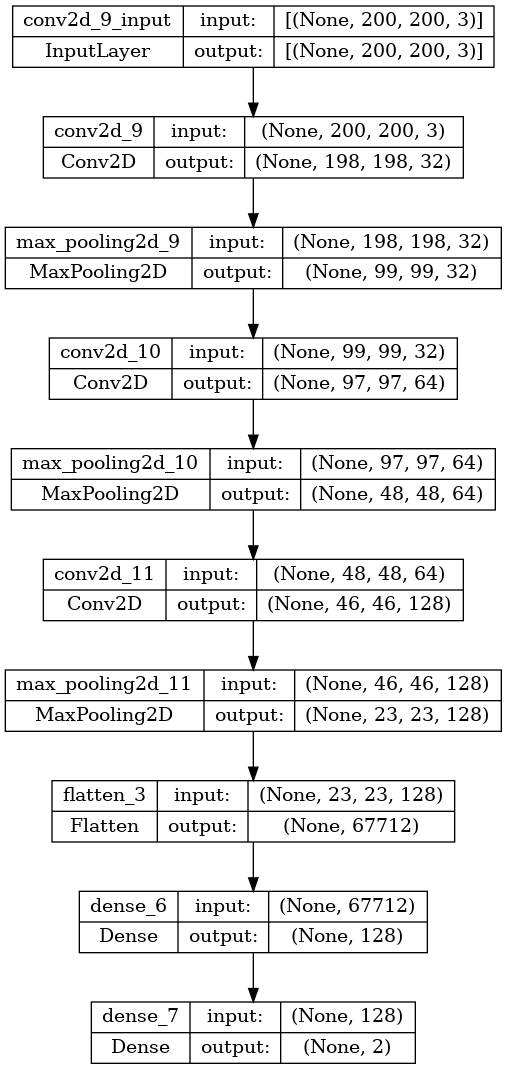

In [80]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True,to_file='binaryclass model.png')


In [81]:
from keras.metrics import Precision,Recall
import tensorflow_addons as tfa

In [82]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy',Precision(name='precision'),Recall(name='Recall'),tfa.metrics.F1Score(num_classes=2)])

In [83]:
history = model.fit(x_train,y_train, epochs=20,batch_size=100,
                    validation_data = val_generator.flow(x_val,y_val,batch_size=100),
                   validation_steps=150,
                   verbose=1)
history=history.history
model.save('/kaggle/working/binary_model.h5')

Epoch 1/20
37/37 [==============================] - 19s 476ms/step - loss: 15.1378 - accuracy: 0.7535 - precision: 0.7311 - Recall: 0.7747 - f1_score: 0.6930 - val_loss: 0.6863 - val_accuracy: 0.7459 - val_precision: 0.7471 - val_Recall: 0.7453 - val_f1_score: 0.4320
Epoch 2/20
37/37 [==============================] - 2s 60ms/step - loss: 0.1723 - accuracy: 0.9333 - precision: 0.9350 - Recall: 0.9276 - f1_score: 0.9155
Epoch 3/20
37/37 [==============================] - 2s 60ms/step - loss: 0.1121 - accuracy: 0.9566 - precision: 0.9574 - Recall: 0.9577 - f1_score: 0.9450
Epoch 4/20
37/37 [==============================] - 2s 60ms/step - loss: 0.0935 - accuracy: 0.9672 - precision: 0.9659 - Recall: 0.9666 - f1_score: 0.9585
Epoch 5/20
37/37 [==============================] - 2s 62ms/step - loss: 0.0824 - accuracy: 0.9726 - precision: 0.9715 - Recall: 0.9718 - f1_score: 0.9652
Epoch 6/20
37/37 [==============================] - 2s 60ms/step - loss: 0.0985 - accuracy: 0.9642 - precision: 

**CNN MODEL EVALUATION**

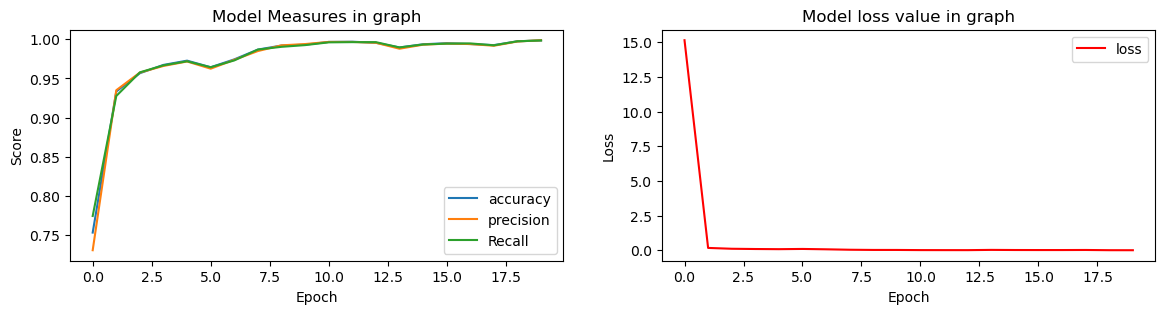

In [85]:
fig = plt.figure(figsize=(14, 3))
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(history['accuracy'])
ax1.plot(history['precision'])
ax1.plot(history["Recall"])
ax1.legend(['accuracy','precision','Recall'])
ax1.set_title('Model Measures in graph')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Score')

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(history['loss'],color='red')
ax2.legend(['loss'])
ax2.set_title('Model loss value in graph')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')

plt.savefig('graph1.png')
plt.savefig('graph2.png')
plt.show()

**TEST SET**

In [109]:
testscore=model.evaluate(x_test,y_test)
testscore

19/19 [==============================] - 0s 9ms/step - loss: 0.3251 - accuracy: 0.9488 - precision: 0.9485 - Recall: 0.9437 - f1_score: 0.9385


[0.3250717222690582,
 0.9488054513931274,
 0.9485419988632202,
 0.9436860084533691,
 array([0.9132948, 0.9636804], dtype=float32)]

In [93]:
print('TEST DATA')
print('')
print(f"Accuracy: {round(testscore[1]*100,2)}%")
print(f"Precision: {round(testscore[2]*100,2)}%")
print(f"Recall: {round(testscore[3]*100,2)}%")
print(f"F1_score: {testscore[4]}")
print(f"Loss: {testscore[0]}")

TEST DATA

Accuracy: 94.88%
Precision: 94.85%
Recall: 94.37%
F1_score: [0.9132948 0.9636804]
Loss: 0.3250717222690582


In [94]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [95]:
y_pred=np.argmax(model.predict(x_test),axis=1)
y_true=np.argmax(y_test,axis=1)

19/19 [==============================] - 0s 6ms/step


In [96]:
c_test=confusion_matrix(y_true,y_pred)
c_test

array([[158,  19],
       [ 11, 398]])

In [97]:
print(classification_report(y_true,y_pred,target_names=['NORMAL','PNEUMONIA']))

              precision    recall  f1-score   support

      NORMAL       0.93      0.89      0.91       177
   PNEUMONIA       0.95      0.97      0.96       409

    accuracy                           0.95       586
   macro avg       0.94      0.93      0.94       586
weighted avg       0.95      0.95      0.95       586



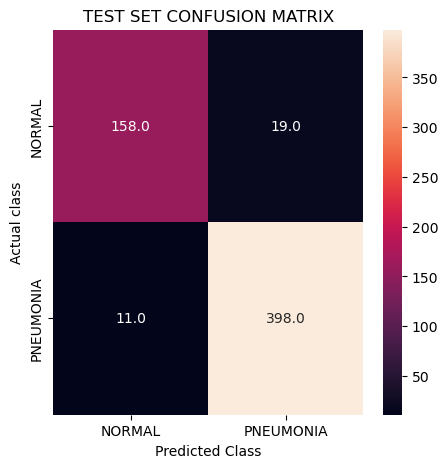

In [98]:
class_names=['NORMAL','PNEUMONIA']
plt.figure(figsize=(5,5))
sns.heatmap(c_test,annot=True,xticklabels=class_names,yticklabels=class_names,fmt='.1f')
plt.title('TEST SET CONFUSION MATRIX')
plt.xlabel("Predicted Class")
plt.ylabel("Actual class")
plt.savefig('cm test.png')
plt.show()

In [100]:
print(f"TEST SET")
print('')
for i in range(2):
    tp = c_test[i, i]
    tn = np.sum(c_test) - np.sum(c_test[i, :]) - np.sum(c_test[:, i]) + c_test[i, i]
    fp = np.sum(c_test[:, i]) - c_test[i, i]
    fn = np.sum(c_test[i, :]) - c_test[i, i]
    print(f"Class {i}: TP={tp}, TN={tn}, FP={fp}, FN={fn}")

TEST SET

Class 0: TP=158, TN=398, FP=11, FN=19
Class 1: TP=398, TN=158, FP=19, FN=11


**VALIDATION SET ANALYSIS**

In [101]:
valscore=model.evaluate(x_val,y_val)
valscore

50/50 [==============================] - 1s 10ms/step - loss: 0.2868 - accuracy: 0.9431 - precision: 0.9468 - Recall: 0.9343 - f1_score: 0.9243


[0.28680965304374695,
 0.9431099891662598,
 0.9468289613723755,
 0.9342604279518127,
 array([0.88664985, 0.9620252 ], dtype=float32)]

In [102]:
print('VALIDATION DATA')
print('')
print(f"Accuracy: {round(valscore[1]*100,2)}%")
print(f"Precision: {round(valscore[2]*100,2)}%")
print(f"Recall: {round(valscore[3]*100,2)}%")
print(f"F1_score: {valscore[4]}")
print(f"Loss: {valscore[0]}")

VALIDATION DATA

Accuracy: 94.31%
Precision: 94.68%
Recall: 93.43%
F1_score: [0.88664985 0.9620252 ]
Loss: 0.28680965304374695


In [103]:
yv_pred=np.argmax(model.predict(x_val),axis=1)
yv_true=np.argmax(y_val,axis=1)

50/50 [==============================] - 0s 7ms/step


In [104]:
c_val=confusion_matrix(yv_true,yv_pred)
c_val

array([[ 352,   52],
       [  38, 1140]])

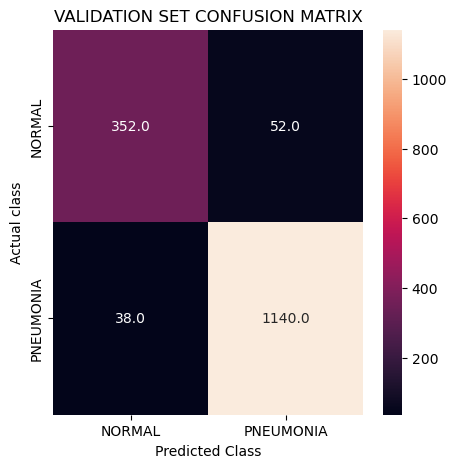

In [105]:
plt.figure(figsize=(5,5))
sns.heatmap(c_val,annot=True,xticklabels=class_names,yticklabels=class_names,fmt='.1f')
plt.title('VALIDATION SET CONFUSION MATRIX')
plt.xlabel("Predicted Class")
plt.ylabel("Actual class")
plt.savefig('cm VAL.png')
plt.show()

In [106]:
print(classification_report(yv_true,yv_pred,target_names=['NORMAL','PNEUMONIA']))

              precision    recall  f1-score   support

      NORMAL       0.90      0.87      0.89       404
   PNEUMONIA       0.96      0.97      0.96      1178

    accuracy                           0.94      1582
   macro avg       0.93      0.92      0.92      1582
weighted avg       0.94      0.94      0.94      1582



In [107]:
print(f"VALIDATION SET")
print('')
for i in range(2):
    tp = c_val[i, i]
    tn = np.sum(c_val) - np.sum(c_val[i, :]) - np.sum(c_val[:, i]) + c_val[i, i]
    fp = np.sum(c_val[:, i]) - c_val[i, i]
    fn = np.sum(c_val[i, :]) - c_val[i, i]
    print(f"Class {i}: TP={tp}, TN={tn}, FP={fp}, FN={fn}")

VALIDATION SET

Class 0: TP=352, TN=1140, FP=38, FN=52
Class 1: TP=1140, TN=352, FP=52, FN=38


**IMAGE PREDICTIONS WITH PERCENTAGES**

1/1 [==============================] - 0s 15ms/step


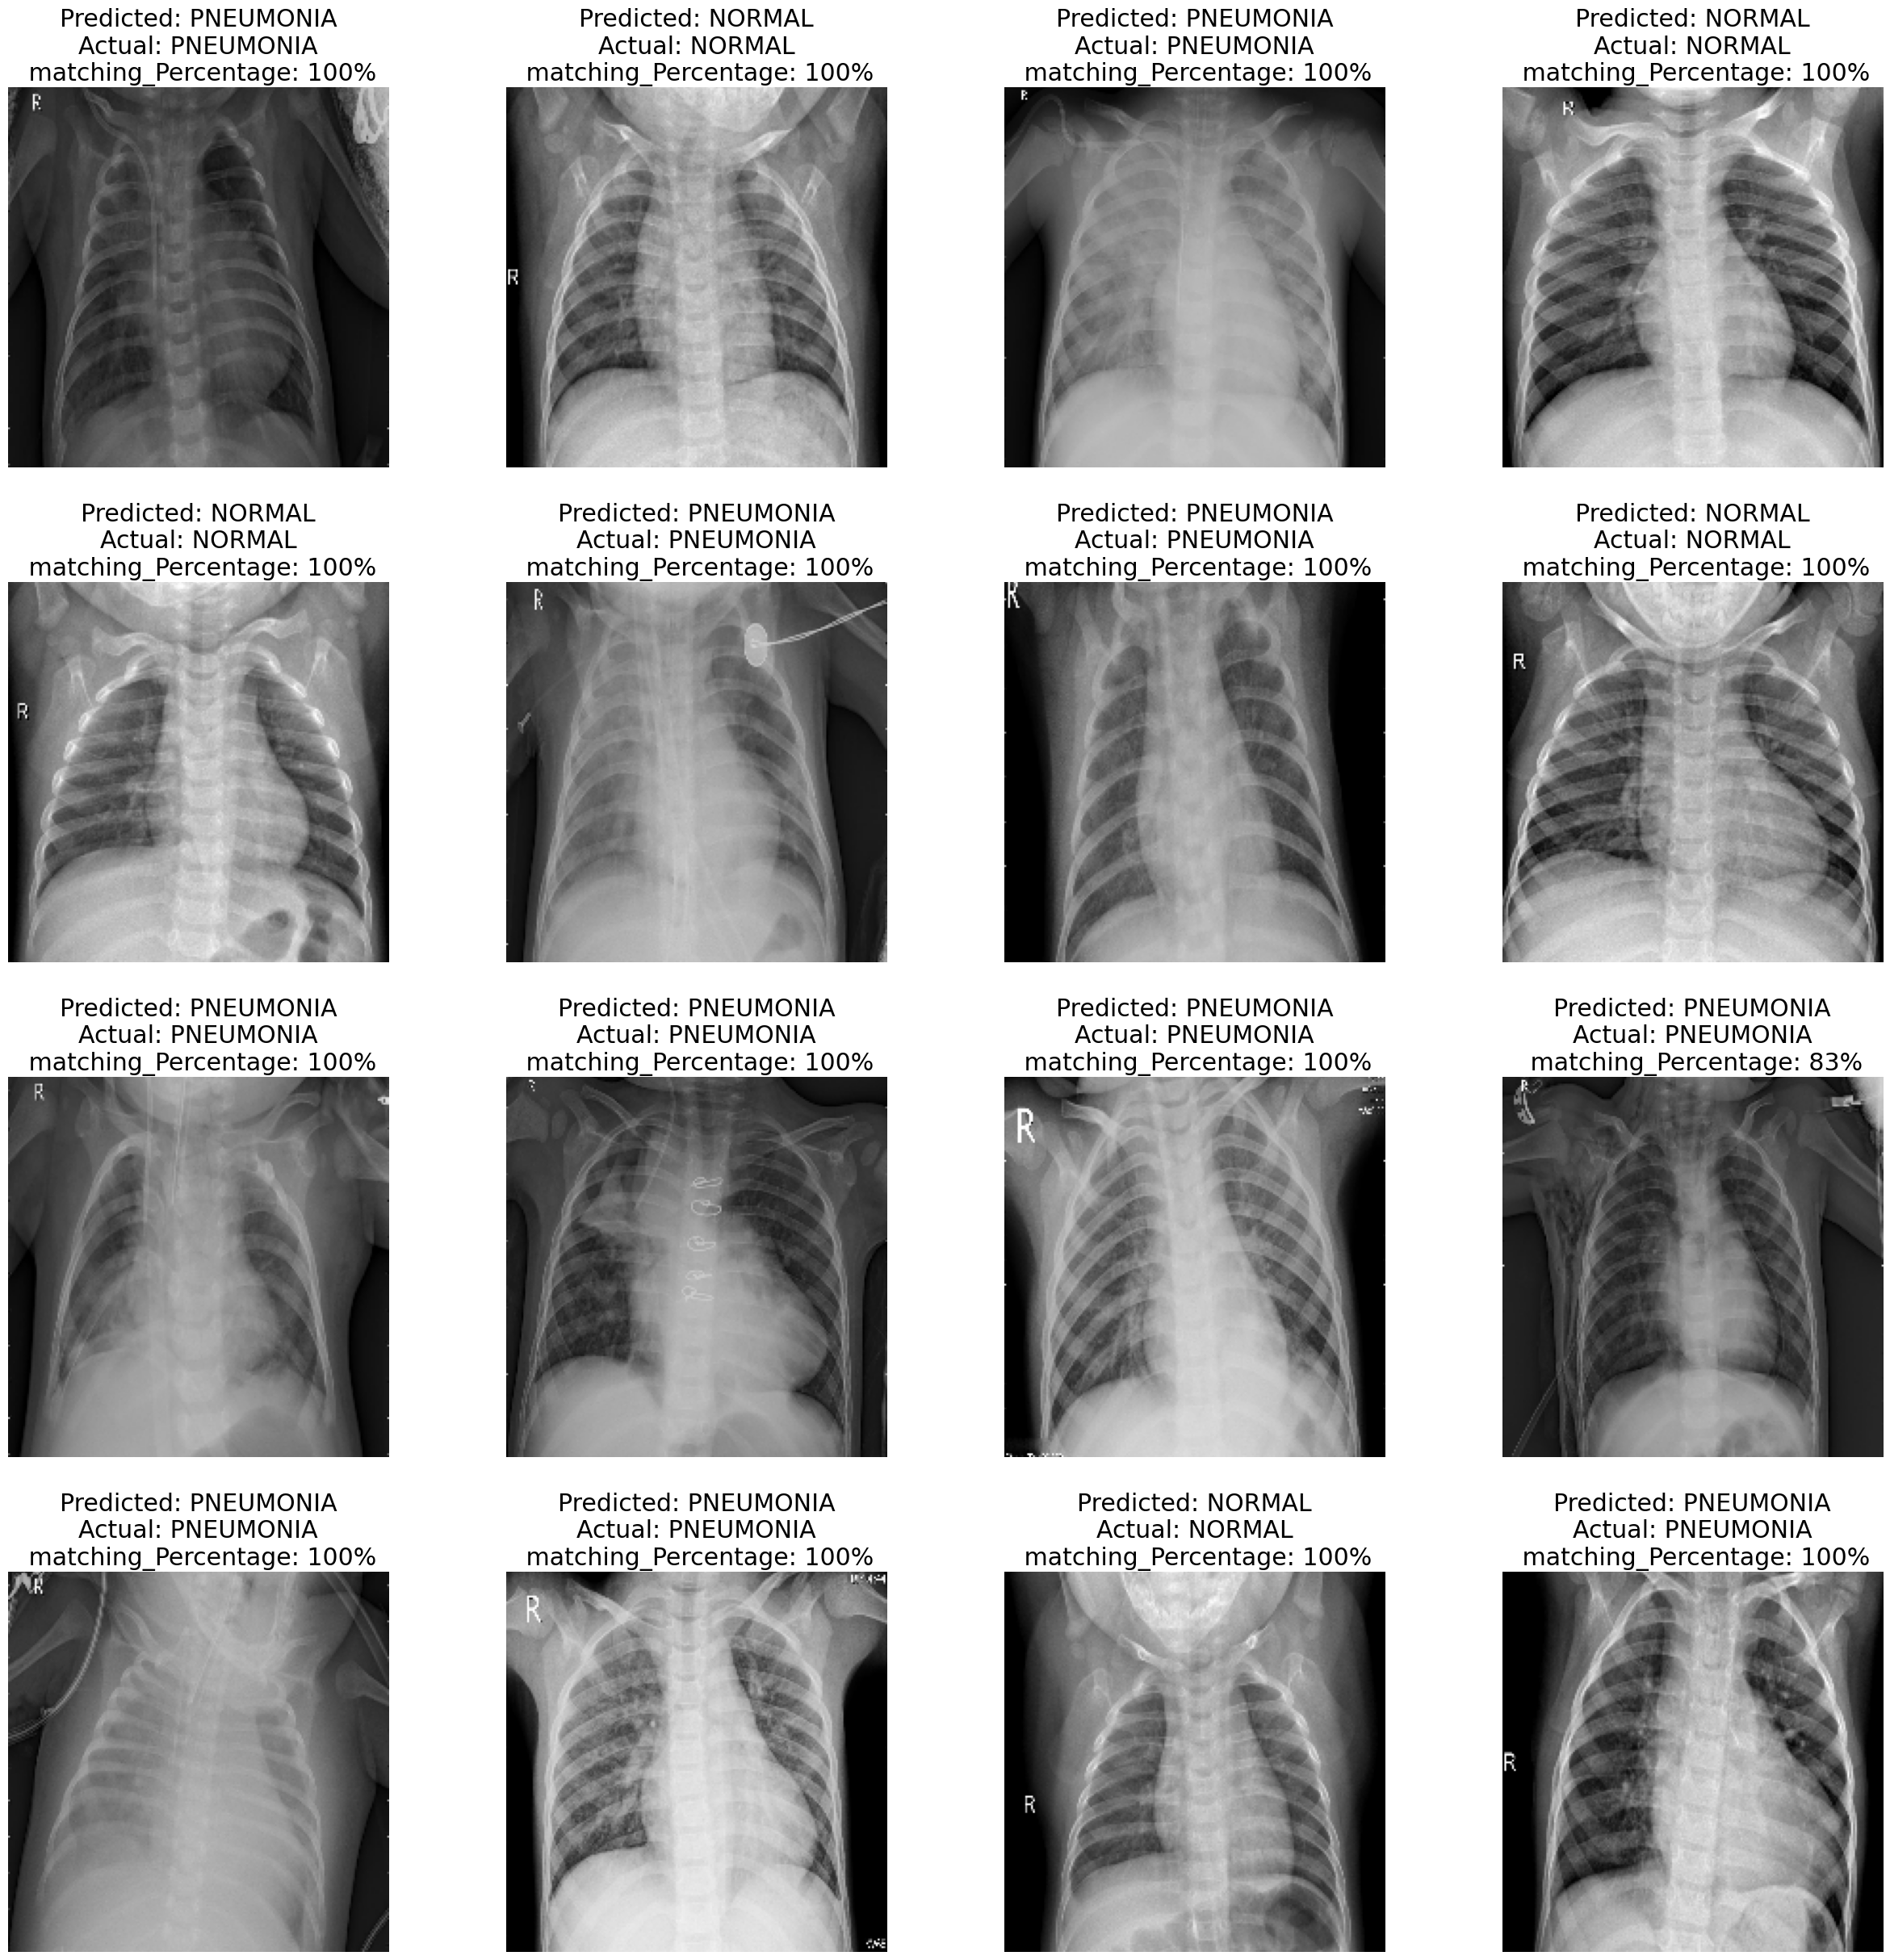

In [97]:

plt.figure(figsize=(30, 30))
plt.subplots_adjust(wspace=0.3, hspace=0.3)
for i in range(16):
    idx = np.random.randint(len(y))
    img, true_class = x[idx], categories[y[idx].squeeze()]

    # predict class probabilities for the current image
    probs = model.predict(img[None, :, :, :])[0]
    pred_class = categories[np.argmax(probs)]
    max_prob = np.max(probs)*100
    plt.rcParams.update({'font.size':18})
    plt.subplot(4, 4, i + 1)
    plt.imshow(img[:, :, ::-1])
    plt.title(f"Predicted: {pred_class}\nActual: {true_class}\n matching_Percentage: {round(max_prob)}%")
    plt.axis("off")
plt.show()